In [486]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date, time
from prophet import Prophet
from numpy import mean, max, maximum, quantile
from prophet.diagnostics import performance_metrics, cross_validation
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

In [487]:
DELTA = 40
AGG = 20
FREQ = str(AGG) + 'min'

In [488]:
transactions = pd.read_csv('transactions.csv', header=0, index_col=0)
df = transactions.drop(['Value'], axis=1)
df = df.sort_index()
df.index = pd.to_datetime(df.index)
df = df.groupby(pd.Grouper(level='Date', freq=FREQ)).mean()

In [489]:
start_date = datetime.combine(date(2021, 10, 16), time(3,0)) 
end_date = datetime.combine(date(2021, 10, 17), time(6,0))

start_date, end_date

(datetime.datetime(2021, 10, 16, 3, 0), datetime.datetime(2021, 10, 17, 6, 0))

In [490]:
# train_df = df[:'2021-10-16 02:59:59']
# test_df = df['2021-10-16 03:00:00':]

In [491]:
def prepare_df(df):
   df = df.reset_index() 
   df = df.rename(columns = {'Date':'ds', 'Price': 'y'}, inplace=False)
   return df

In [492]:
# train_df = prepare_df(train_df)
# test_df = prepare_df(test_df)

df = prepare_df(df)
df

,ds,y
0,2021-01-01 00:00:00,8.084088e+10
1,2021-01-01 00:20:00,8.024579e+10
2,2021-01-01 00:40:00,7.701433e+10
3,2021-01-01 01:00:00,8.713914e+10
4,2021-01-01 01:20:00,7.425917e+10
...,...,...
20947,2021-10-18 22:20:00,1.139328e+11
20948,2021-10-18 22:40:00,9.914658e+10
20949,2021-10-18 23:00:00,8.993732e+10
20950,2021-10-18 23:20:00,7.477979e+10


In [493]:
m = Prophet(changepoint_prior_scale=0.0005,yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=True, interval_width=0.10)
m.fit(df)

/home/andras/.local/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [494]:
cutoffs = pd.to_datetime(['2021-01-16 03:00:00', '2021-10-16 03:00:00', '2021-10-17 06:00:00'])
df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='27hours')

  0%|          | 0/3 [00:00<?, ?it/s]

/home/andras/.local/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/andras/.local/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/andras/.local/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/andras/.local/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_co

In [495]:
df_p = performance_metrics(df_cv2)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 02:40:00,2.361153e+21,4.859169e+10,4.167083e+10,0.615800,0.503723,0.430175,0.041667
1,0 days 03:00:00,2.374941e+21,4.873337e+10,4.174774e+10,0.627746,0.523064,0.435128,0.041667
2,0 days 03:20:00,2.329324e+21,4.826307e+10,4.147869e+10,0.626348,0.523728,0.435176,0.041667
3,0 days 03:40:00,2.325016e+21,4.821842e+10,4.239699e+10,0.645172,0.523728,0.449362,0.000000
4,0 days 04:00:00,2.197307e+21,4.687545e+10,4.054849e+10,0.615237,0.523728,0.429742,0.041667
...,...,...,...,...,...,...,...,...
69,1 days 01:40:00,3.095327e+21,5.563567e+10,5.108208e+10,0.775611,0.614431,0.528436,0.000000
70,1 days 02:00:00,3.149854e+21,5.612356e+10,5.132070e+10,0.792842,0.614431,0.534725,0.000000
71,1 days 02:20:00,3.154510e+21,5.616503e+10,5.117840e+10,0.801858,0.593994,0.537056,0.000000
72,1 days 02:40:00,3.149940e+21,5.612433e+10,5.102804e+10,0.812996,0.594458,0.540212,0.000000


Text(0.5, 1.0, 'Root Mean Squared Error using Prophet')

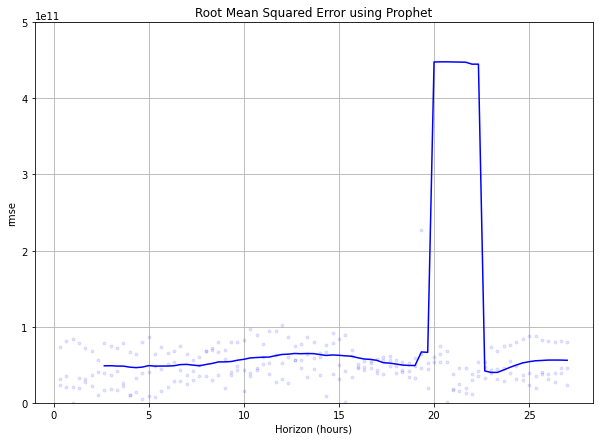

In [496]:
fig = plot_cross_validation_metric(df_cv2, metric='rmse', figsize=(10, 7))
ax = fig.gca()
ax.set_ylim(0, 0.5e12)
ax.set_title('Root Mean Squared Error using Prophet')


Text(0.5, 1.0, 'Predicted versus actual using Prophet')

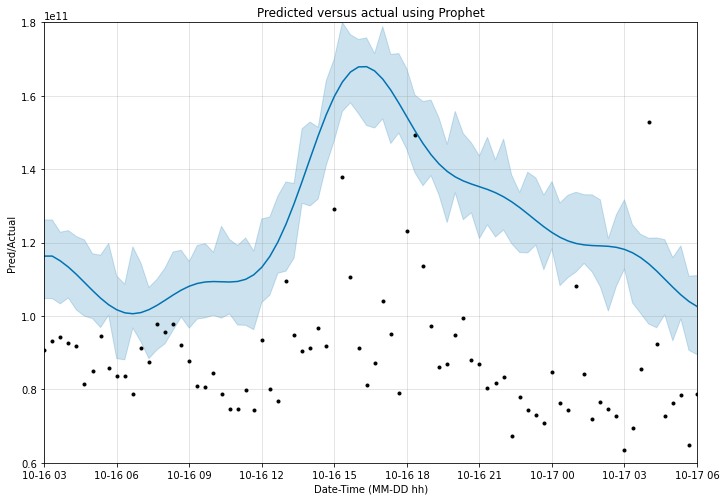

In [502]:
fig = m.plot(df_cv2, figsize=(10, 7), xlabel='Date-Time (MM-DD hh)', ylabel='Pred/Actual')
ax = fig.gca()
ax.set_xlim([start_date, end_date])
ax.set_ylim(0.6e11, 1.8e11)
ax.set_title('Predicted versus actual using Prophet 10% pred. interval')